#0. Introduction

This personal finance programme aims to help the user track expenses, income and investments 

In detail the user can:
- Record expenses,revenues
- Update the portfolio through open and closed positions
- Control expenses,revenues and investments

#1. Packages Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

#2. Defining Functions

In [2]:
#Starting functions

def operation_choice():
  """ Function asking the user which operation to do
      
      Args:

      Returns:
      selected_operation (string) : letter corresponding to operation selected
  """
  print('Which operation do you want to perform?')
  print('A) Report an expense')
  print('B) Report a revenue')
  print('C) Update your portfolio of investments')
  print('D) Monitor Expenses&Revenues')
  print('E) Monitor investments')
  selected_operation=str(input('Please enter the corresponding letter:'))
  return selected_operation



def start_pf():
  """ Function initializing expense,revenues and investments empty dataframe
      
      Args:

      Returns:
      edf (pd.DataFrame) : empty dataframe with defined columns designed host expenses
      rdf (pd.DataFrame) : empty dataframe with defined columns designed host revenues
      idf (pd.DataFrame) : empty dataframe with defined columns designed host investments

  """
  edf=pd.DataFrame(columns=['Date','Reason','Amount','Category'])
  rdf=pd.DataFrame(columns=['Date','Reason','Amount','Category'])
  idf=pd.DataFrame(columns=['Date','YF_Ticker','Category','Price','Quantity','Position','Exposure'])
  return edf,rdf,idf

In [3]:
#Functions (and their building blocks) to update existing dataframes 

def update_expenses(edf):
  """ Function to add an expense to the existing expenses dataframe
      
      Args:
      edf (pd.DataFrame) : expenses dataframe

      Returns:
      edf (pd.DataFrame) : updated expenses dataframe
      
  """
  try:
    day=pd.to_datetime(input('Enter the day in which the expense occured in the form yyyy-mm-dd:')).date()
    reason=str(input('Enter the specific expenditure reason:'))
    amount=float(input('Enter the expense amount:'))
    category=str(input('Enter the category in which the expense will be reported:'))
    n_exp={'Date':day,'Reason':reason,'Amount':amount,'Category':category}
    edf=edf.append(n_exp,ignore_index=True)
    print('\nHere your expense \n')
    print(edf.tail(1))
  except:
    print('\nUnfortunately, some problems have arisen with the inputs')    
  return edf




def update_revenues(rdf):
  """ Function to add a revenue to the existing expenses dataframe 
      
      Args:
      rdf (pd.DataFrame) : revenues dataframe

      Returns:
      rdf (pd.DataFrame) : updated revenues dataframe
      
  """  
  try:
    day=pd.to_datetime(input('Enter the day in which the revenue occured in the form yyyy-mm-dd:')).date()
    reason=str(input('Enter the specific revenue reason:'))
    amount=float(input('Enter the revenue amount:'))
    category=str(input('Enter the category in which the revenue will be reported:'))
    n_rev={'Date':day,'Reason':reason,'Amount':amount,'Category':category}
    rdf=rdf.append(n_rev,ignore_index=True)
    print('\nHere your revenue \n')
    print(rdf.tail(1))
  except:
    print('\nUnfortunately, some problems have arisen with the inputs')
  return rdf 



# pl_simple necessary for update_inv function

def pl_simple(dtfr,n,cp):
  """Function to get the profit/loss of a closed position

  Args:
  dftr (pd.DataFrame) : investments dataframe (including a Long/Short column in position indexed 5)
  n (int) : index of the closed position
  cp (int) : closing price

  Returns:
  pfls (float) : profit/loss deriving from the closed position

  """
  if dtfr.iloc[n,5]=='L':
    pfls=(cp-dtfr.iloc[n,3])*dtfr.iloc[n,4]     # Long position profit --> (closing price - buying price) * quantity
  else:
    pfls=(dtfr.iloc[n,3]-cp)*dtfr.iloc[n,4]     # Short position --> (buying price - closing price) * quantity
  return pfls



def update_inv(idf,edf,rdf):
  """ Function to update investments and, in some case, consequently also revenues and expenses dataframes 
      Why also revenues/expenses? Because when you close an investing position profits fall in revenues df and losses in expenses one 

      Args: 
      idf (pd.DataFrame) : investments dataframe
      edf (pd.DataFrame) : expenses dataframe
      rdf (pd.DataFrame) : revenues dataframe

      Returns:
      idf (pd.DataFrame) : updated investments dataframe
      edf (pd.DataFrame) : updated expenses dataframe
      rdf (pd.DataFrame) : updated revenues dataframe
  """
  try:
    print('Do you want to record a position closed or a new open?')
    ooc=str(input('Enter the letter(O/C): ')).upper()
    day=pd.to_datetime(input('Enter the day in which it occured in the form yyyy-mm-dd:')).date()
    if ooc=='O':
      ticker=str(input('Enter the Yahoo! Finance Ticker: '))
      category=str(input('Enter the category (Stock,Bond, or Commodity): '))
      price=float(input('Enter the price: '))
      quantity=float(input('Enter the quantity: '))
      position=str(input('Enter the Position (Long or Short) with L or S: '))
      n_inv={'Date':day,'YF_Ticker':ticker,'Category':category,'Price':price,'Quantity':quantity,'Position':position}
      idf=idf.append(n_inv,ignore_index=True)
      print('\nHere your new open position \n')
      print(idf.tail(1))
    elif ooc=='C':
      print('\nWhich position did you close? \n ')
      print(idf)
      pclosed=int(input('Enter the corresponding index: '))
      closing_p=float(input('Enter the closing price: '))
      pl=pl_simple(idf,pclosed,closing_p)
      if pl>=0:
        nw={'Date':day,'Reason':str(idf.iloc[pclosed,1]+' Position closed'),'Amount':pl,'Category':'Investment'}
        rdf=rdf.append(nw,ignore_index=True)
        print('\nThe closed position has been added to the revenues in the following way: \n ')
        print(rdf.tail(1))
      else:
        nw={'Date':day,'Reason':str(idf.iloc[pclosed,1]+' Position closed'),'Amount':-pl,'Category':'Investment'}
        edf=edf.append(nw,ignore_index=True)
        print('\nThe closed position has been added to the negative flows (expenses) in the following way: \n ')
        print(edf.tail(1))
        idf=idf.drop(pclosed)
    else:
        print('\nUnfortunately you did not select one of the possible operations')
  except:
    print('\nUnfortunately, some problems have arisen with the inputs')
  return idf,edf,rdf 

In [4]:
#Control Functions (and their building blocks)

def monitor_exp_rev(ex_df,rv_df):
  """Function to monitor expenses and revenues.
     In particular the user can check:
      - One-period list of expenses and expenses by category plus chance to compare expenses in two different timespans 
      - One-period list of revenues and revenues by category plus chance to compare revenues in two different timespans 
      - all cash flows, E&R graphs by category and balance(rev-exp) over time

      Args:
      ex_df (pd.DataFrame) : expenses df
      rv_df (pd.DataFrame) : revenues df

      Returns:
      ()
      
      This function does not return any object but only summarized info in the form of tables and/or graphs

  """
  try:
    print('What do you want to check?')
    print('1) Expenses')
    print('2) Revenues')
    print('3) Both')
    sel1=int(input('Please enter the corresponding number:'))
    print('\nNow please choose the period')
    start=pd.to_datetime(input('Please enter the beginning date in the form yyyy-mm-dd: ')).date()
    end=pd.to_datetime(input('Please enter the last date in the form yyyy-mm-dd: ')).date()
    ex_col_dict={'Food':'darkorange','Subscriptions':'darkred','Transports':'dimgrey','Items':'darkorchid','House':'darkslategrey','Health & Personal care':'aqua','Taxes':'sienna','Gift':'fuchsia','Travel':'darkgreen','Leisure':'gold','Education':'limegreen','General Expenses':'khaki','Investment':''}
    rv_col_dict={'Wage':'b','Gambling':'g','Investment':'y','Extra':'c','Bonus':'m'}
    if sel1==1:
      ex_df_di=ex_df.set_index('Date').sort_index()
      ex_df_sel=ex_df_di.loc[start:end].copy()
      ex_df_grouped_cat=ex_df_sel.groupby(['Category'])['Amount'].agg(['sum','mean'])
      ex_df_grouped_cat['Percentage Share (%)']=100*ex_df_grouped_cat['sum']/(ex_df_grouped_cat['sum'].sum())
      print('\nThe list of your expenses in the selected period \n \r')
      print(ex_df_sel)
      print('\nYour expenses in the selected period grouped by category  \n \r')
      print(ex_df_grouped_cat)
      additional_op=str(input('Do you want to compare this period with another one? (Yes/No) :'))
      if additional_op=='Yes':
        print('\n \rNow please choose the second period')
        start2=pd.to_datetime(input('Please enter the beginning date in the form yyyy-mm-dd: ')).date()
        end2=pd.to_datetime(input('Please enter the beginning date in the form yyyy-mm-dd: ')).date()
        ex_df_sel_compare=ex_df_di.loc[start2:end2].copy()
        ex_df_cmp_gcat=ex_df_sel_compare.groupby(['Category'])['Amount'].agg(['sum','mean'])
        ex_df_cmp_gcat['Percentage Share (%)']=100*ex_df_cmp_gcat['sum']/(ex_df_cmp_gcat['sum'].sum())
        print('\nThe list of your expenses in this second selected period \n \r')
        print(ex_df_sel_compare)
        print('\nYour expenses in the second period grouped by category  \n \r')
        print(ex_df_cmp_gcat)
        fig,ax=plt.subplots(1,2)
        fig.set_size_inches([13,13])
        ax[0].pie(ex_df_grouped_cat['sum'],labels=ex_df_grouped_cat.index,autopct='%.2f',colors=[ex_col_dict[key] for key in ex_df_grouped_cat.index])
        ax[0].set_title('First period selected')
        ax[1].pie(ex_df_cmp_gcat['sum'],labels=ex_df_cmp_gcat.index,autopct='%.2f',colors=[ex_col_dict[key] for key in ex_df_cmp_gcat.index])
        ax[1].set_title('Second period selected')
        ex_df_sel['Period']=1
        ex_df_sel_compare['Period']=2
        exp_2p=ex_df_sel.append(ex_df_sel_compare)
        exp_2p_gpc=exp_2p.groupby(['Period','Category'])['Amount'].sum()
        print('\nHere the expenses grouped by category in the two periods and the corresponding graphs \n \r')
        print(exp_2p_gpc)  
        plt.show()     
      else:
        print('\nThe graph representing the expenses by category')
        fig,ax=plt.subplots()
        fig.set_size_inches([7,11])
        ax.pie(ex_df_grouped_cat['sum'],labels=ex_df_grouped_cat.index,autopct='%.2f',colors=[ex_col_dict[key] for key in ex_df_grouped_cat.index])
        ax.set_title('Expenses by category')
        plt.show()
    elif sel1==2:
      rv_df_di=rv_df.set_index('Date').sort_index()
      rv_df_sel=rv_df_di.loc[start:end].copy()
      rv_df_grouped_cat=rv_df_sel.groupby(['Category'])['Amount'].agg(['sum','mean'])
      rv_df_grouped_cat['Percentage Share (%)']=round(100*rv_df_grouped_cat['sum']/(rv_df_grouped_cat['sum'].sum()),2)
      print('\nThe list of your revenues in the selected period \n \r')
      print(rv_df_sel)
      print('\nYour revenues in the selected period grouped by category  \n \r')
      print(rv_df_grouped_cat)
      additional_op=str(input('Do you want to compare this period with another one? (Yes/No): '))
      if additional_op=='Yes':
        print('\nNow please choose the second period')
        start2=pd.to_datetime(input('Please enter the beginning date in the form yyyy-mm-dd: ')).date()
        end2=pd.to_datetime(input('Please enter the beginning date in the form yyyy-mm-dd: ')).date()
        rv_df_sel_compare=rv_df_di.loc[start2:end2].copy()
        rv_df_cmp_gcat=rv_df_sel_compare.groupby(['Category'])['Amount'].agg(['sum','mean'])
        rv_df_cmp_gcat['Percentage Share (%)']=100*rv_df_cmp_gcat['sum']/(rv_df_cmp_gcat['sum'].sum())
        print('\nThe list of your revenues in this second selected period \n \r')
        print(rv_df_sel_compare)
        print('\nYour revenues in the second period grouped by category  \n \r')
        print(rv_df_cmp_gcat)
        fig,ax=plt.subplots(1,2)
        fig.set_size_inches([13,13])
        ax[0].pie(rv_df_grouped_cat['sum'],labels=rv_df_grouped_cat.index,autopct='%.2f',colors=[rv_col_dict[key] for key in rv_df_grouped_cat.index])
        ax[0].set_title('First period selected')
        ax[1].pie(rv_df_cmp_gcat['sum'],labels=rv_df_cmp_gcat.index,autopct='%.2f',colors=[rv_col_dict[key] for key in rv_df_cmp_gcat.index])
        ax[1].set_title('Second period selected')
        rv_df_sel['Period']=1
        rv_df_sel_compare['Period']=2
        rv_2p=rv_df_sel.append(rv_df_sel_compare)
        rv_2p_gpc=rv_2p.groupby(['Period','Category'])['Amount'].sum()
        print('\nHere the revenues grouped by category in the two periods and the corresponding graphs')
        print(rv_2p_gpc)
        plt.show()      
      else:
        print('\nThe graph representing the revenues by category in the selected period')
        fig,ax=plt.subplots()
        fig.set_size_inches([7,11])
        ax.pie(rv_df_grouped_cat['sum'],labels=rv_df_grouped_cat.index,autopct='%.2f',colors=[rv_col_dict[key] for key in rv_df_grouped_cat.index])
        ax.set_title('Revenues by category')
        plt.show()
    elif sel1==3:
      ex_df_di=ex_df.set_index('Date').sort_index()
      ex_df_sel=ex_df_di.loc[start:end]
      ex_df_grouped_cat=ex_df_sel.groupby(['Category'])['Amount'].agg(['sum','mean'])
      ex_df_grouped_cat['Percentage Share (%)']=100*ex_df_grouped_cat['sum']/(ex_df_grouped_cat['sum'].sum())
      rv_df_di=rv_df.set_index('Date').sort_index()
      rv_df_sel=rv_df_di.loc[start:end]
      rv_df_grouped_cat=rv_df_sel.groupby(['Category'])['Amount'].agg(['sum','mean'])
      rv_df_grouped_cat['Percentage Share (%)']=100*rv_df_grouped_cat['sum']/(rv_df_grouped_cat['sum'].sum())
      ex_df_sign=ex_df_sel.copy()
      ex_df_sign['Amount']=-ex_df_sign['Amount']
      overall_df=ex_df_sign.append(rv_df_sel)
      overall_df=overall_df.sort_index()
      overall_df['Balance']=overall_df['Amount'].cumsum()
      print('\nExpenses and Revenues occured in the choosen period \n \r')
      print(overall_df)
      print('\nGraphs of E&R by category and of the balance during the timespan')
      fig,ax=plt.subplots(3,1)
      fig.set_size_inches([13,16])
      ax[0].pie(ex_df_grouped_cat['sum'],labels=ex_df_grouped_cat.index,autopct='%.2f',colors=[ex_col_dict[key] for key in ex_df_grouped_cat.index])
      ax[0].set_title('Expenses pie chart')
      ax[1].pie(rv_df_grouped_cat['sum'],labels=rv_df_grouped_cat.index,autopct='%.2f',colors=[rv_col_dict[key] for key in rv_df_grouped_cat.index])
      ax[1].set_title('Revenues pie chart')
      ax[2].plot(overall_df.index,overall_df['Balance'])
      ax[2].set_title('Exp-Rev Balance across the period')
      ax[2].set_xlabel('Time')
      ax[2].set_ylabel('Money')
      plt.show()
    else:
      print('\nOperation choice not supported')
  except:
    print('\nUnfortunately, some problems have arisen')




# get_current_prices,pnl used in monitor_inv function
        
def get_current_prices(invdf):
  """ Function returning the current prices for any ticker in the investments df

      Args: 
      invdf (pd.DataFrame) : investments dataframe with a 'YF_Ticker' column

      Returns:
      current_prices (list) : list of current prices (corresponding to investment ticker)
  """
  current_prices=[]
  for i,r in invdf.iterrows():
    stock=yf.Ticker(r['YF_Ticker'])
    live_price=stock.info['regularMarketPrice']
    current_prices.append(live_price)
  return current_prices
    
def pnl(invdf):
  """ Function returning the current profit and losses of the open positions

      Args: 
      invdf (pd.DataFrame) : investments dataframe with 'Position'(Long/Short as L/S),'Current_Value' (current total value of the position) and 'Exposure' (opening value) columns

      Returns:
      pl (list) : list of P&L in absolute terms
  """
  pl=[]
  for i,r in invdf.iterrows():
    if r['Position']=='L':
      d=r['Current_Value']-r['Exposure']
    else:
      d=r['Exposure']-r['Current_Value']
    pl.append(d)
  return pl




def monitor_inv(invst_df):
  """ Function to monitor the investments portfolio through visualization tools

      Args:
      invst_df (pd.DataFrame) : investments dataframe 

      Returns:
      ()

      This function does not return any object but only summarized info in the form of tables and/or graphs
  """
  idfs=invst_df.set_index('Date').sort_index().copy()
  idfs['Exposure']=idfs['Price']*idfs['Quantity']
  cp_list=get_current_prices(idfs)
  idfs['Current_Price']=cp_list
  idfs['Current_Value']=idfs['Current_Price']*idfs['Quantity']
  pl_list=pnl(idfs)
  idfs['P_L']=pl_list
  idfs['P&L(%)']=100*idfs['P_L']/idfs['Exposure']
  idfs['Portfolio_weight(%)']=100*idfs['Current_Value']/idfs['Current_Value'].sum()
  idf3_gcat=idfs.groupby('Category')['Current_Value'].agg(['sum','mean'])
  idf3_gtick=idfs.groupby('YF_Ticker')['Current_Value'].agg(['sum','mean'])
  cv=idfs['Current_Value'].sum()
  tot_pl=idfs['P_L'].sum()
  tot_pl_pct=100*tot_pl/idfs['Exposure'].sum()
  iv_dict={'Stock':'darkorange','Bond':'deepskyblue','Commodity':'forestgreen'}
  fig,ax=plt.subplots(1,2)
  fig.set_size_inches([13,13])
  ax[0].pie(idf3_gcat['sum'],labels=idf3_gcat.index,autopct='%.1f',colors=[iv_dict[key] for key in idf3_gcat.index])
  ax[0].set_title('Portfolio in categories')
  ax[1].pie(idf3_gtick['sum'],labels=idf3_gtick.index,autopct='%.1f')
  ax[1].set_title('Portfolio weights')
  print(idfs[['YF_Ticker','Position','Exposure','Current_Value','P_L','P&L(%)']])
  if tot_pl>=0:
    print('\nYour portfolio is worth',str(round(cv,2)),'and your current profit is +',str(round(tot_pl,2)),'(+',str(round(tot_pl_pct,3)),'%)')
  else:
    print('\nYour portfolio is worth',str(round(cv,2)),'and your current loss is',str(round(tot_pl,2)),'(',str(round(tot_pl_pct,3)),'%)')            
  print('\nPortfolio pie charts by category and single financial instruments')
  plt.show()

#3. Program

In [ ]:
print('This is your personal finance programme')
expenses_df,revenues_df,inv_df=start_pf() 
cond=True
while cond:
    operation=operation_choice().upper()
    print('')
    if operation=='EXIT':
        cond=False
    elif operation=='A':
        expenses_df=update_expenses(expenses_df)
    elif operation=='B':
        revenues_df=update_revenues(revenues_df)
    elif operation=='C':
        inv_df,expenses_df,revenues_df=update_inv(inv_df,expenses_df,revenues_df)
    elif operation=='D':
        monitor_exp_rev(expenses_df,revenues_df)
    elif operation=='E':
        monitor_inv(inv_df)  
    else:
        print('Please try again')
    print('\n','-'*75,'\n')

#4. Example

Since a lot of time would be necessary to fill dataframes we define a new function to start that provides dataframes full of fictional data in order to go directly to all program functionalities

In [5]:
def start_example():
  """ Function initializing expense,revenues and investments dataframe full of fictional data
      
      Args:

      Returns:
      edf (pd.DataFrame) : expenses dataframe 
      rdf (pd.DataFrame) : revenues dataframe 
      idf (pd.DataFrame) : investment dataframe 
  """
  exp_dict={'Date':[pd.to_datetime('2022-07-02').date(),pd.to_datetime('2022-07-03').date(),pd.to_datetime('2022-07-14').date(),pd.to_datetime('2022-07-24').date(),pd.to_datetime('2022-08-05').date(),pd.to_datetime('2022-08-07').date()],'Reason':['Car Fuel','Restaurant Dinner','Highway','Coop shopping','Flight BLQ-PAL','Mobile phone charge'],'Amount':[20.0,42.23,17.12,36.96,48.14,20.0],'Category':['Transports','Food','Transports','Food','Travel','Subscriptions']}
  rev_dict={'Date':[pd.to_datetime('2022-05-02').date(),pd.to_datetime('2022-06-03').date(),pd.to_datetime('2022-07-03').date(),pd.to_datetime('2022-07-21').date(),pd.to_datetime('2022-08-03').date()],'Reason':['Salary','Salary','Salary','Friend Consultancy','State Bonus'],'Amount':[1200.0,1200.0,1200.0,220.0,184.0],'Category':['Wage','Wage','Wage','Extra','Bonus']}
  inv_dict={'Date':[pd.to_datetime('2022-04-11').date(),pd.to_datetime('2022-05-20').date(),pd.to_datetime('2022-06-04').date(),pd.to_datetime('2022-07-19').date(),pd.to_datetime('2022-08-04').date()],'YF_Ticker':['LQD','META','HG=F','C','RSG'],'Category':['Bond','Stock','Commodity','Stock','Stock'],'Price':[116.1,173.21,4.32,44.67,128.12],'Quantity':[2,3,100,1,4],'Position':['L','L','S','L','L']}
  edf=pd.DataFrame(exp_dict)
  rdf=pd.DataFrame(rev_dict)
  idf=pd.DataFrame(inv_dict)
  return edf,rdf,idf

This is your personal finance programme
Which operation do you want to perform?
A) Report an expense
B) Report a revenue
C) Update your portfolio of investments
D) Monitor Expenses&Revenues
E) Monitor investments
Please enter the corresponding letter:a

Enter the day in which the expense occured in the form yyyy-mm-dd:2022-09-12
Enter the specific expenditure reason:Restaurant Dinner
Enter the expense amount:28
Enter the category in which the expense will be reported:Food

Here your expense 

         Date             Reason  Amount Category
6  2022-09-12  Restaurant Dinner    28.0     Food

 --------------------------------------------------------------------------- 

Which operation do you want to perform?
A) Report an expense
B) Report a revenue
C) Update your portfolio of investments
D) Monitor Expenses&Revenues
E) Monitor investments
Please enter the corresponding letter:c

Do you want to record a position closed or a new open?
Enter the letter(O/C): o
Enter the day in which it oc

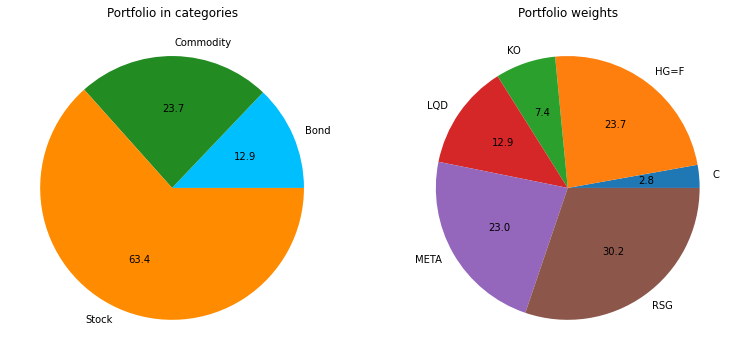


 --------------------------------------------------------------------------- 

Which operation do you want to perform?
A) Report an expense
B) Report a revenue
C) Update your portfolio of investments
D) Monitor Expenses&Revenues
E) Monitor investments
Please enter the corresponding letter:d

What do you want to check?
1) Expenses
2) Revenues
3) Both
Please enter the corresponding number:3

Now please choose the period
Please enter the beginning date in the form yyyy-mm-dd: 2022-01-01
Please enter the last date in the form yyyy-mm-dd: 2022-12-30

Expenses and Revenues occured in the choosen period 
 
                         Reason   Amount       Category  Balance
Date                                                            
2022-05-02               Salary  1200.00           Wage  1200.00
2022-06-03               Salary  1200.00           Wage  2400.00
2022-07-02             Car Fuel   -20.00     Transports  2380.00
2022-07-03    Restaurant Dinner   -42.23           Food  2337.77
20

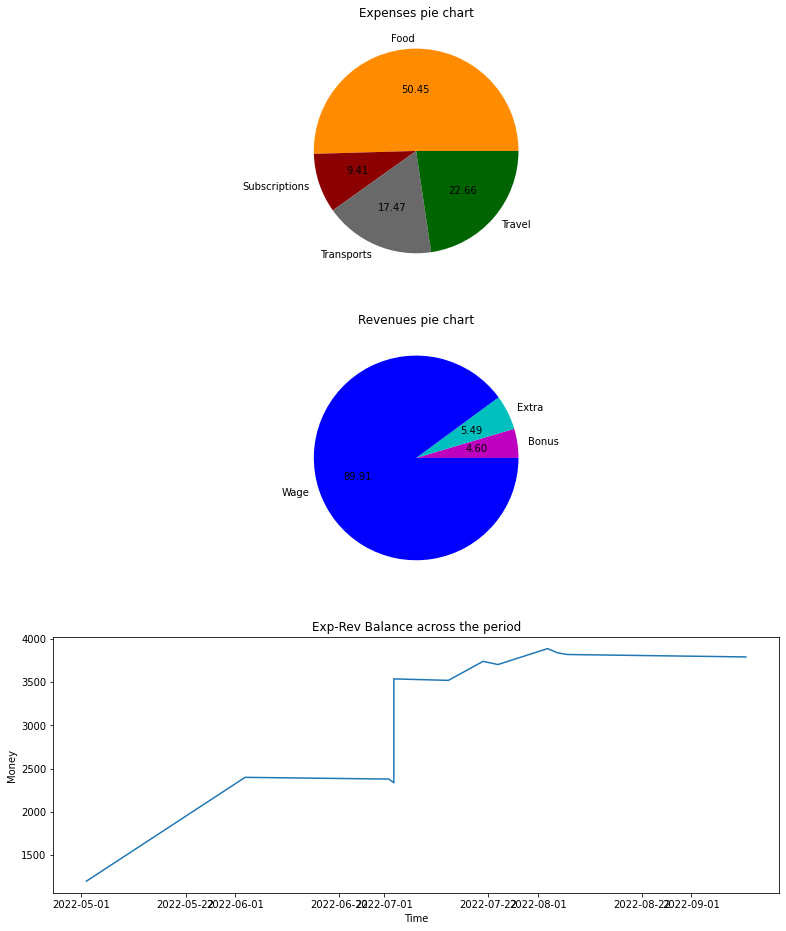


 --------------------------------------------------------------------------- 

Which operation do you want to perform?
A) Report an expense
B) Report a revenue
C) Update your portfolio of investments
D) Monitor Expenses&Revenues
E) Monitor investments
Please enter the corresponding letter:exit


 --------------------------------------------------------------------------- 



In [9]:
print('This is your personal finance programme')
expenses_df,revenues_df,inv_df=start_example() 
cond=True
while cond:
    operation=operation_choice().upper()
    print('')
    if operation=='EXIT':
        cond=False
    elif operation=='A':
        expenses_df=update_expenses(expenses_df)
    elif operation=='B':
        revenues_df=update_revenues(revenues_df)
    elif operation=='C':
        inv_df,expenses_df,revenues_df=update_inv(inv_df,expenses_df,revenues_df)
    elif operation=='D':
        monitor_exp_rev(expenses_df,revenues_df)
    elif operation=='E':
        monitor_inv(inv_df)  
    else:
        print('Please try again')
    print('\n','-'*75,'\n')